In [4]:
# !pip install --user tables
# !pip install imblearn
# !pip3 install --force-reinstall tensorflow==2.8.0 --user 
# !pip3 install --upgrade tensorflow-gpu --user
# !pip3 install tensorflow_datasets --user
# !pip3 install numba
# !pip3 install PyWavelets
# !pip3 install imageio
# !pip3 install scikit-image
# !pip3 install psutil

import os, h5py, re, time, pywt, imageio, pickle, psutil, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.combine import SMOTETomek, SMOTEENN
from tqdm.auto import tqdm
tqdm.pandas()

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
# from joblib import Parallel, delayed
# import numba as nb
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
import numpy as np   

from skimage.restoration import (denoise_wavelet, estimate_sigma)
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import MinMaxScaler

import keras_tuner as kt
from tensorflow import keras
from IPython.display import clear_output
import typing

from tensorflow_addons.utils.types import AcceptableDTypes
from typeguard import typechecked

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [5]:
df = pd.read_csv('merge.csv')
df.head()

C:\Users\Zhafran\.conda\envs\ExVodka\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (7,11,13,14,15,18,19,20,21,22,24,25,26,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
0,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-21 05:55:00,noise,109C.TA_201510210555_NO
1,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-06 14:50:00,noise,109C.TA_201511061450_NO
2,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-07 02:20:00,noise,109C.TA_201511070220_NO
3,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-14 05:15:00,noise,109C.TA_201511140515_NO
4,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-25 18:50:00,noise,109C.TA_201512251850_NO


In [6]:
def RandomUnderSampler(df_earthquake, random_state=24, size_underSample=20000):
    np.random.seed(random_state)
    index = np.random.randint(0, len(df_earthquake)+1, size=size_underSample)
    return df_earthquake.loc[index].reset_index(drop=True)

df_noise = df[df['trace_category']=='noise'][['p_arrival_sample', 's_arrival_sample',
                                              'source_magnitude', 'trace_name', 'trace_category']]
df_noise = df_noise.reset_index(drop=True)
df_noise = df_noise.fillna(-1)

df_earthquake = df[df['trace_category']=='earthquake_local'][['p_arrival_sample', 's_arrival_sample',
                                                              'source_magnitude', 'trace_name', 'trace_category']]
df_earthquake = df_earthquake.reset_index(drop=True)
df_earthquake_sample = RandomUnderSampler(df_earthquake, size_underSample=df_noise.shape[0],
                                   random_state=24)

In [7]:
df_2 = pd.concat([df_earthquake_sample, df_noise]).reset_index(drop=True)
rate = .1/1000 # 0<=rate<=1, ketika rate 1 mengambil seluruh data (balanced), ketika 0 tidak ada data yg di ambil
df_2_slice = df_earthquake.groupby('trace_category', group_keys=False).apply(lambda x: x.sample(int(len(df_earthquake)*rate))) 

print(f'''
{display(df_earthquake.sample(5))}

DataFrame 2 Shape       : {df_earthquake.shape}
DataFrame 2 Sliced Shape: {df_2_slice.shape}
''')

,p_arrival_sample,s_arrival_sample,source_magnitude,trace_name,trace_category
527399,400.0,473.0,1.93,GDXB.NC_20130721134219_EV,earthquake_local
770755,1000.0,3768.0,3.50,OHAK.AT_20180927151929_EV,earthquake_local
23292,500.0,1893.0,3.30,ALN.HT_20100914071737_EV,earthquake_local
60135,700.0,809.0,1.46,B067.PB_20141204201722_EV,earthquake_local
607313,700.0,792.0,1.67,ID06.GS_20170912111559_EV,earthquake_local



None

DataFrame 2 Shape       : (1030231, 5)
DataFrame 2 Sliced Shape: (103, 5)



In [8]:
X = df_2_slice['trace_name']
y = df_2_slice[['s_arrival_sample', 'source_magnitude']]
y['s_arrival_sample'] = y['s_arrival_sample'].map(lambda x: np.log(x))
y['source_magnitude'] = y['source_magnitude'].map(lambda x: np.log1p(x))

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=0.8)
# X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, train_size=0.5)

print(f'''
X_train Shape: {X_train_val.shape}
X_test  Shape: {X_test.shape}
''')


X_train Shape: (82,)
X_test  Shape: (21,)



C:\Users\Zhafran\AppData\Local\Temp/ipykernel_3872/2002802016.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['s_arrival_sample'] = y['s_arrival_sample'].map(lambda x: np.log(x))
C:\Users\Zhafran\AppData\Local\Temp/ipykernel_3872/2002802016.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['source_magnitude'] = y['source_magnitude'].map(lambda x: np.log1p(x))


In [9]:
def get_waveform(trace_name):
    '''
    Kolom 1: East-West Channel
    Kolom 2: North-South Channel
    Kolom 3: Z (Vertical) Channel
    '''
    filename = "merge.hdf5"
    with h5py.File(filename, "r") as f:
        data = f.get('data/'+trace_name)
        data = np.array(data)
    return data

In [10]:
# def DenoiseWavelet(data, type='BayesShrink'):
#     def BayesShrink():
#         im_bayes = denoise_wavelet(np.array(data), convert2ycbcr=True, multichannel=True,
#                                    method='BayesShrink', mode='soft', 
#                                    rescale_sigma=True, wavelet_levels=4)
#         return im_bayes
    
#     def VisuShrink():
#         sigma_est = estimate_sigma(np.array(data), multichannel=True, average_sigmas=True)
#         im_visu = denoise_wavelet(np.array(img), convert2ycbcr=True, multichannel=True,
#                                   method='VisuShrink', mode='soft', wavelet_levels=4,
#                                   sigma=sigma_est, rescale_sigma=True)
        
#         return im_visu
    
#     if type=='BayesShrink':
#         return BayesShrink()
#     elif type=='VisuShrink':
#         return VisuShrink()

# def create_data(data_feature, data_label, BATCH=32):
#     def create_feature():
#         rs = []
#         for t in tqdm(data_feature.values):
#             data_l = get_waveform(t)
#             data_denoise = DenoiseWavelet(data_l, type='BayesShrink')
#             rs.append(data_denoise)
#         return tf.stack(rs)
    
#     def create_label():
#         return np.array(data_label.values)
    
#     def create_dataset(feature, label): 
#         feature_dt = tf.data.Dataset.from_tensor_slices(feature)
#         label_dt = tf.data.Dataset.from_tensor_slices(label)

#         dt = tf.data.Dataset.zip((feature_dt, label_dt))
#         dt = dt.cache().shuffle(buffer_size=BATCH)
#         dt = dt.batch(BATCH).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
#         return dt
    
#     feature = create_feature()
#     label = create_label()
    
#     ts_dt = create_dataset(feature, label)
#     print(f'\n{ts_dt}\n')
#     return ts_dt

# dt_train = create_data(data_feature=X_train,
#                        data_label=y_train)

# dt_val = create_data(data_feature=X_val,
#                      data_label=y_val)

# dt_test = create_data(data_feature=X_test,
#                       data_label=y_test)

In [11]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

def DenoiseWavelet(data, type='BayesShrink'):
    def BayesShrink():
        im_bayes = denoise_wavelet(np.array(data), convert2ycbcr=True, multichannel=True,
                                   method='BayesShrink', mode='soft', 
                                   rescale_sigma=True, wavelet_levels=4)
        return im_bayes
    
    def VisuShrink():
        sigma_est = estimate_sigma(np.array(data), multichannel=True, average_sigmas=True)
        im_visu = denoise_wavelet(np.array(img), convert2ycbcr=True, multichannel=True,
                                  method='VisuShrink', mode='soft', wavelet_levels=4,
                                  sigma=sigma_est, rescale_sigma=True)
        
        return im_visu
    
    if type=='BayesShrink':
        return BayesShrink()
    elif type=='VisuShrink':
        return VisuShrink()

def create_data_2(data_feature, data_label, BATCH=128):
    def create_feature():
        rs = []
        for t in tqdm(data_feature.values):
            data_l = get_waveform(t)
            data_denoise = DenoiseWavelet(data_l, type='BayesShrink')
            rs.append(data_denoise)
        return np.array(rs)
    
    def create_label():
        return np.array(data_label.values)
    
    def create_dataset(feature, label): 
        gen = DataGenerator(feature, label, BATCH)
        return gen
    
    feature = create_feature()
    label = create_label()
    
#     ts_dt = create_dataset(feature, label)
#     print(f'\n{ts_dt}\n')
    return {'feature':feature, 'label':label}

In [16]:
# data_json = create_data_2(data_feature=X,
#                           data_label=y)
y

,s_arrival_sample,source_magnitude
661657,6.930495,0.307485
520036,6.635947,0.444686
672343,7.673564,0.875469
856665,7.324358,0.741937
734731,6.909753,0.932164
...,...,...
107818,6.817831,1.029619
443066,7.251345,1.261298
731434,7.249651,1.064711
396214,6.599885,0.631272


In [ ]:
data_json

In [48]:
# dt_val = create_data_2(data_feature=X_val,
#                      data_label=y_val)

In [7]:
# json_test = create_data_2(data_feature=X_test,
#                           data_label=y_test)

In [39]:
%%time

datas_ = [dt_train, dt_val, dt_test]
types_ = ['Train', 'Val', 'Test']

for data_, type_ in zip(datas_, types_):
    data_json = {}
    data_json.update({
        'X':data_.x,
        'y':data_.y,
        'Batch':data_.batch_size
    })
    path = os.path.join(os.getcwd(), 'Prefetch Dataset', 'v2 - 50%', f'{type_}.json')
    with open(path, 'wb') as fp:
        pickle.dump(data_json, fp)

Wall time: 2min 16s


In [2]:
%%time
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
    
path = os.path.join(os.getcwd(), 'Prefetch Dataset', 'v2 - 50%')

with open(os.path.join(path, 'Train.json'), 'rb') as fp:
    dt_train = pickle.load(fp)

with open(os.path.join(path, 'Val.json'), 'rb') as fp:
    dt_val = pickle.load(fp)

with open(os.path.join(path, 'Test.json'), 'rb') as fp:
    dt_test = pickle.load(fp)

dt_train = DataGenerator(dt_train['X'], dt_train['y'], 196)
dt_val = DataGenerator(dt_val['X'], dt_val['y'], 196)
dt_test = DataGenerator(dt_test['X'], dt_test['y'], 196)

Wall time: 28 s


In [12]:
tf.keras.backend.clear_session()

def model_builder(hp):
    model = keras.Sequential()
    
    model.add(tf.keras.layers.Input((6000, 3)))
    
    for layer_conv in range(hp.Int('layer_conv_', 1, 5)):
        hp_unit = hp.Int('units_'+str(layer_conv), 32, 256, step=32)
        hp_kernel = hp.Int('kernels_'+str(layer_conv), 1, 9, step=1)
        is_activation = hp.Choice('is_activation', ['ReLU', 'LeakyReLU'])
        alpha_leaky_relu = hp.Float('alpha_leakyReLU_'+str(layer_conv),
                                    0.1, 0.5, step=0.1)
        is_pool = hp.Choice("is_pool", ["avg", "max"])

        
        model.add(tf.keras.layers.Conv1D(filters=hp_unit,
                                         kernel_size=hp_kernel))
        model.add(tf.keras.layers.BatchNormalization())
        if is_activation=='ReLU':
            with hp.conditional_scope('is_activation', ['ReLU']):
                model.add(tf.keras.layers.Activation('relu'))
        elif is_activation=='LeakyReLU':
            with hp.conditional_scope('is_activation', ['LeakyReLU']):
                model.add(tf.keras.layers.LeakyReLU(alpha=alpha_leaky_relu))
                
        if is_pool == "avg":
            with hp.conditional_scope("is_pool", ["avg"]):
                model.add(tf.keras.layers.AveragePooling1D())
        if is_pool == "max":
            with hp.conditional_scope("is_pool", ["max"]):
                model.add(tf.keras.layers.MaxPooling1D())
    
    hp_unit_gru = hp.Int('units_gru_', 64, 128, step=32)
    model.add(tf.keras.layers.GRU(units=hp_unit_gru, return_sequences=True)) 
    model.add(tf.keras.layers.Flatten())
    
    for layer_dense in range(hp.Int('layer_dense_', 2, 4)):
        hp_unit_dense = hp.Int('units_'+str(layer_dense), 64, 256, step=32)
        hp_unit_dropout_dense = hp.Float('dropout_dense_', 0.1, 0.5, step=0.1)
        
        model.add(tf.keras.layers.Dense(units=hp_unit_dense))
        model.add(tf.keras.layers.Dropout(rate=hp_unit_dropout_dense))
        
    model.add(tf.keras.layers.Dense(2))
    model.compile(optimizer=tf.keras.optimizers.Adam(), #tfa.optimizers.LazyAdam(),
              loss=tf.keras.losses.MeanSquaredError())
    return model

tuner = kt.BayesianOptimization(model_builder,
                     objective=kt.Objective("val_loss", direction="min"),
                     max_trials=20,
                     project_name='HyperParam Tuner S-Wave and Magnitude -2-',
                     directory=os.path.join(os.getcwd(), 'HyperParameter Tuner Log'))

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=5, min_lr=0.0001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# tuner.search(dt_train, validation_data=dt_val,
#              epochs=15,
#              use_multiprocessing=True,
#              workers=4)

INFO:tensorflow:Reloading Oracle from existing project C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\HyperParameter Tuner Log\HyperParam Tuner S-Wave and Magnitude -2-\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\HyperParameter Tuner Log\HyperParam Tuner S-Wave and Magnitude -2-\tuner0.json


In [13]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
# model.save('model-visu.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 6000, 32)          128       
                                                                 
 batch_normalization_1 (Batc  (None, 6000, 32)         128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 6000, 32)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3000, 32)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 3000, 256)         8448      
                                                                 
 batch_normalization_2 (Batc  (None, 3000, 256)       

In [134]:
# Save the entire model as a SavedModel.
model.save(os.path.join(os.getcwd(), 'Model Checkpoint', 'v3 (S-Wave 1)'))

INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v3 (S-Wave 1)\assets


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v3 (S-Wave 1)\assets


In [6]:
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-0, 1e-1, 1e-2])
wd = lambda: 1e-4 * schedule(step)

opt_adam = tf.keras.optimizers.Adam()
opt_lazyAdam = tfa.optimizers.LazyAdam()
opt_adamW = tfa.optimizers.AdamW(weight_decay=wd)
opt_adaBelief = tfa.optimizers.AdaBelief()

opt_json = {
    'Adam':opt_adam,
    'Lazy Adam':opt_lazyAdam,
    'AdamW':opt_adamW,
    'Ada Belief':opt_adaBelief
}

In [8]:
history_loss = {}
for opt_name, opt_ in opt_json.items():
    print(f'===== {opt_name} In Training =====')
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                                                     patience=5, min_lr=0.0001, verbose=1)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    model.compile(optimizer=opt_, loss=tf.keras.losses.MeanSquaredError())
    history = model.fit(dt_train, validation_data=dt_val, epochs=15,
                        callbacks=[reduce_lr, early_stop])
    history_loss.update({
        opt_name:history.history['val_loss']
    })
    print('\n\n\n')

===== Adam In Training =====
Epoch 1/15
1315/1315 [==============================] - 329s 247ms/step - loss: 0.4101 - val_loss: 0.1309 - lr: 0.0010
Epoch 2/15
1315/1315 [==============================] - 325s 247ms/step - loss: 0.1139 - val_loss: 0.1504 - lr: 0.0010
Epoch 3/15
1315/1315 [==============================] - 325s 247ms/step - loss: 0.0624 - val_loss: 0.0917 - lr: 0.0010
Epoch 4/15
1315/1315 [==============================] - 325s 247ms/step - loss: 0.0497 - val_loss: 0.0723 - lr: 0.0010
Epoch 5/15
1315/1315 [==============================] - 325s 247ms/step - loss: 0.0452 - val_loss: 0.1031 - lr: 0.0010
Epoch 6/15
1315/1315 [==============================] - 325s 247ms/step - loss: 0.0431 - val_loss: 0.1139 - lr: 0.0010
Epoch 7/15
1315/1315 [==============================] - ETA: 0s - loss: 0.0405

KeyboardInterrupt: 

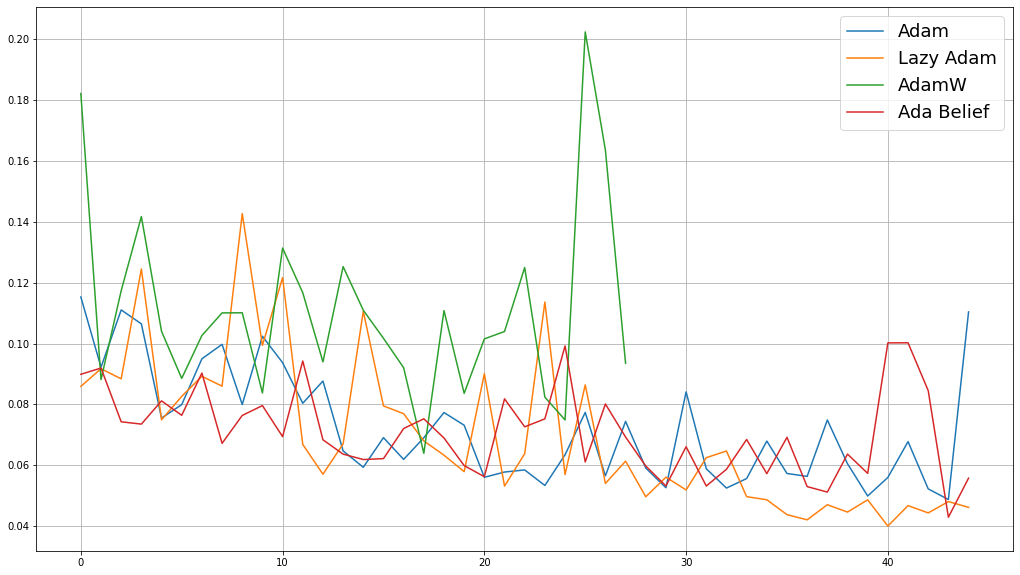

In [32]:
plt.figure(figsize=(17.5,10))

for opt_name, losses in history_loss.items():
    plt.plot(losses[5:], label=opt_name)
    
plt.grid()
plt.legend(prop={'size':18})
plt.show()

In [35]:
best_opt = tfa.optimizers.LazyAdam()
LA_opt_1 = tfa.optimizers.Lookahead(best_opt, sync_period=5, slow_step_size=.5)
LA_opt_2 = tfa.optimizers.Lookahead(best_opt, sync_period=5, slow_step_size=.8)
LA_opt_3 = tfa.optimizers.Lookahead(best_opt, sync_period=10, slow_step_size=.5)
LA_opt_4 = tfa.optimizers.Lookahead(best_opt, sync_period=10, slow_step_size=.8)

LA_opt_json = {
    'Baseline':best_opt,
    'α=.5, k=5':LA_opt_1,
    'α=.8, k=5':LA_opt_2,
    'α=.5, k=10':LA_opt_3,
    'α=.8, k=10':LA_opt_4,
}

In [36]:
LA_history_loss = {}
for opt_name, opt_ in LA_opt_json.items():
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                                                     patience=5, min_lr=0.0001, verbose=1)
    if opt_name=='Baseline':
        continue
    print(f'===== {opt_name} In Training =====')
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    model.compile(optimizer=opt_, loss=tf.keras.losses.MeanSquaredError())
    history = model.fit(dt_train, validation_data=dt_val, epochs=50,
                        callbacks=[reduce_lr, early_stop])
    LA_history_loss.update({
        opt_name:history.history['val_loss']
    })

===== α=.5, k=5 In Training =====
Epoch 1/50
805/805 [==============================] - 57s 65ms/step - loss: 1.0143 - val_loss: 0.3076 - lr: 0.0010
Epoch 2/50
805/805 [==============================] - 52s 64ms/step - loss: 0.2626 - val_loss: 0.1451 - lr: 0.0010
Epoch 3/50
805/805 [==============================] - 52s 64ms/step - loss: 0.1824 - val_loss: 0.1302 - lr: 0.0010
Epoch 4/50
805/805 [==============================] - 52s 64ms/step - loss: 0.1467 - val_loss: 0.1017 - lr: 0.0010
Epoch 5/50
805/805 [==============================] - 52s 64ms/step - loss: 0.1135 - val_loss: 0.0961 - lr: 0.0010
Epoch 6/50
805/805 [==============================] - 52s 64ms/step - loss: 0.0892 - val_loss: 0.0831 - lr: 0.0010
Epoch 7/50
805/805 [==============================] - 52s 64ms/step - loss: 0.0711 - val_loss: 0.0819 - lr: 0.0010
Epoch 8/50
805/805 [==============================] - 52s 64ms/step - loss: 0.0645 - val_loss: 0.0751 - lr: 0.0010
Epoch 9/50
805/805 [==========================

Epoch 4/50
805/805 [==============================] - 52s 64ms/step - loss: 0.2598 - val_loss: 0.1155 - lr: 1.0000e-04
Epoch 5/50
805/805 [==============================] - 52s 64ms/step - loss: 0.2222 - val_loss: 0.1331 - lr: 1.0000e-04
Epoch 6/50
805/805 [==============================] - 52s 64ms/step - loss: 0.1970 - val_loss: 0.1388 - lr: 1.0000e-04
Epoch 7/50
805/805 [==============================] - 52s 64ms/step - loss: 0.1886 - val_loss: 0.1123 - lr: 1.0000e-04
Epoch 8/50
805/805 [==============================] - 51s 64ms/step - loss: 0.1780 - val_loss: 0.1077 - lr: 1.0000e-04
Epoch 9/50
805/805 [==============================] - 51s 64ms/step - loss: 0.1601 - val_loss: 0.0998 - lr: 1.0000e-04
Epoch 10/50
805/805 [==============================] - 51s 64ms/step - loss: 0.1496 - val_loss: 0.0971 - lr: 1.0000e-04
Epoch 11/50
805/805 [==============================] - 52s 64ms/step - loss: 0.1403 - val_loss: 0.0977 - lr: 1.0000e-04
Epoch 12/50
805/805 [=========================

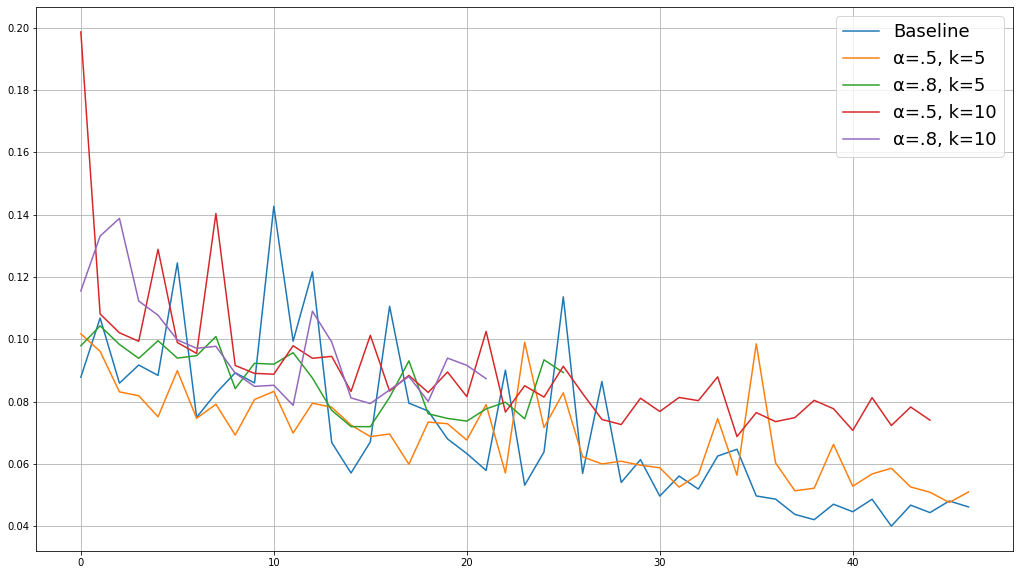

In [37]:
plt.figure(figsize=(17.5,10))

plt.plot(history_loss['Lazy Adam'][3:], label='Baseline')
for opt_name, losses in LA_history_loss.items():
    if opt_name=='Baseline':
        continue
    plt.plot(losses[3:], label=opt_name)
#     plt.scatter()
    
plt.grid()
plt.legend(prop={'size':18})
plt.show()

In [11]:
model

In [14]:
import warnings
warnings.filterwarnings("ignore")

dt_train = DataGenerator(dt_train.x, dt_train.y, 196)
dt_val = DataGenerator(dt_val.x, dt_val.y, 196)
dt_test = DataGenerator(dt_test.x, dt_test.y, 196)

# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                                                 patience=2, min_lr=0.0001, verbose=1)
checkpoint_filepath_epoch = os.path.join(os.getcwd(), 'Model Checkpoint', 'v5 (S-Wave 1)',
                                         'Model Checkpoint Every 2 Epoch')
checkpoint_filepath_best = os.path.join(os.getcwd(), 'Model Checkpoint', 'v5 (S-Wave 1)',
                                         'Model Checkpoint Best', 'Model_Epoch_{epoch}')
model_checkpoint_callback_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_best,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model_checkpoint_callback_epoch = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_epoch,
    save_weights_only=False,
    save_freq=2*dt_train.batch_size)

def GetHumanReadable(size,precision=2):
    suffixes=['B','KB','MB','GB','TB']
    suffixIndex = 0
    while size >= 1024 and suffixIndex < 4:
        suffixIndex += 1 #increment the index of the suffix
        size = size/1024.0 #apply the division
        
    return "%.*f%s"%(precision,size,suffixes[suffixIndex])

class MemoryUsageCallback(tf.keras.callbacks.Callback):
    '''Monitor memory usage on epoch begin and end.'''

    def on_epoch_begin(self,epoch,logs=None):
        print('***** Epoch {} *****'.format(epoch))
        print('Memory usage on epoch begin: {}'.format(GetHumanReadable(psutil.Process(os.getpid()).memory_info().rss)))

    def on_epoch_end(self,epoch,logs=None):
        print(' - Memory usage on epoch end: {}'.format(GetHumanReadable(psutil.Process(os.getpid()).memory_info().rss)))
    
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
final_opt = tfa.optimizers.Lookahead(tfa.optimizers.LazyAdam(),
                                     sync_period=5, slow_step_size=.5)
model.compile(optimizer=final_opt, loss=tf.keras.losses.MeanSquaredError())
history = model.fit(dt_train, validation_data=dt_val, epochs=15,
                    callbacks=[reduce_lr, MemoryUsageCallback(),
                               model_checkpoint_callback_best])

***** Epoch 0 *****
Memory usage on epoch begin: 26.78GB
Epoch 1/15
1972/1972 [==============================] - ETA: 0s - loss: 0.4753 - Memory usage on epoch end: 55.24GB


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_1\assets


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_1\assets


1972/1972 [==============================] - 488s 241ms/step - loss: 0.4753 - val_loss: 0.1358 - lr: 0.0010
***** Epoch 1 *****
Memory usage on epoch begin: 55.37GB
Epoch 2/15
1972/1972 [==============================] - ETA: 0s - loss: 0.1232 - Memory usage on epoch end: 44.58GB


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_2\assets


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_2\assets


1972/1972 [==============================] - 588s 298ms/step - loss: 0.1232 - val_loss: 0.0870 - lr: 0.0010
***** Epoch 2 *****
Memory usage on epoch begin: 44.69GB
Epoch 3/15
1972/1972 [==============================] - 548s 278ms/step - loss: 0.0645 - val_loss: 0.0934 - lr: 0.0010
***** Epoch 3 *****
Memory usage on epoch begin: 39.78GB
Epoch 4/15
1972/1972 [==============================] - ETA: 0s - loss: 0.0513
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
 - Memory usage on epoch end: 39.58GB
1972/1972 [==============================] - 463s 235ms/step - loss: 0.0513 - val_loss: 0.0896 - lr: 0.0010
***** Epoch 4 *****
Memory usage on epoch begin: 39.58GB
Epoch 5/15
1972/1972 [==============================] - ETA: 0s - loss: 0.0448 - Memory usage on epoch end: 39.10GB


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_5\assets


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_5\assets


1972/1972 [==============================] - 466s 236ms/step - loss: 0.0448 - val_loss: 0.0805 - lr: 6.0000e-04
***** Epoch 5 *****
Memory usage on epoch begin: 39.57GB
Epoch 6/15
1972/1972 [==============================] - ETA: 0s - loss: 0.0422 - Memory usage on epoch end: 39.57GB


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_6\assets


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_6\assets


1972/1972 [==============================] - 463s 235ms/step - loss: 0.0422 - val_loss: 0.0774 - lr: 6.0000e-04
***** Epoch 6 *****
Memory usage on epoch begin: 39.56GB
Epoch 7/15
1972/1972 [==============================] - 459s 233ms/step - loss: 0.0396 - val_loss: 0.1882 - lr: 6.0000e-04
***** Epoch 7 *****
Memory usage on epoch begin: 39.56GB
Epoch 8/15
1972/1972 [==============================] - ETA: 0s - loss: 0.0377
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.
 - Memory usage on epoch end: 39.56GB
1972/1972 [==============================] - 459s 233ms/step - loss: 0.0377 - val_loss: 0.0798 - lr: 6.0000e-04
***** Epoch 8 *****
Memory usage on epoch begin: 39.56GB
Epoch 9/15
1972/1972 [==============================] - ETA: 0s - loss: 0.0340 - Memory usage on epoch end: 39.56GB


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_9\assets


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_9\assets


1972/1972 [==============================] - 464s 235ms/step - loss: 0.0340 - val_loss: 0.0651 - lr: 3.6000e-04
***** Epoch 9 *****
Memory usage on epoch begin: 39.57GB
Epoch 10/15
1972/1972 [==============================] - 459s 232ms/step - loss: 0.0324 - val_loss: 0.0775 - lr: 3.6000e-04
***** Epoch 10 *****
Memory usage on epoch begin: 39.56GB
Epoch 11/15
1972/1972 [==============================] - ETA: 0s - loss: 0.0311 - Memory usage on epoch end: 39.56GB


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_11\assets


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_11\assets


1972/1972 [==============================] - 463s 235ms/step - loss: 0.0311 - val_loss: 0.0431 - lr: 3.6000e-04
***** Epoch 11 *****
Memory usage on epoch begin: 39.57GB
Epoch 12/15
1972/1972 [==============================] - ETA: 0s - loss: 0.0301 - Memory usage on epoch end: 39.57GB


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_12\assets


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_12\assets


1972/1972 [==============================] - 463s 235ms/step - loss: 0.0301 - val_loss: 0.0365 - lr: 3.6000e-04
***** Epoch 12 *****
Memory usage on epoch begin: 39.58GB
Epoch 13/15
1972/1972 [==============================] - 460s 233ms/step - loss: 0.0292 - val_loss: 0.0584 - lr: 3.6000e-04
***** Epoch 13 *****
Memory usage on epoch begin: 39.58GB
Epoch 14/15
1972/1972 [==============================] - ETA: 0s - loss: 0.0285 - Memory usage on epoch end: 39.58GB


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_14\assets


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Model Checkpoint Best\Model_Epoch_14\assets


1972/1972 [==============================] - 468s 237ms/step - loss: 0.0285 - val_loss: 0.0321 - lr: 3.6000e-04
***** Epoch 14 *****
Memory usage on epoch begin: 39.60GB
Epoch 15/15
1972/1972 [==============================] - 465s 236ms/step - loss: 0.0277 - val_loss: 0.0498 - lr: 3.6000e-04


In [33]:
path = os.path.join(os.getcwd(), 'Model Checkpoint', 'v5 (S-Wave 1)', 'Best Model')
best_model.save(path)

INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Best Model\assets


INFO:tensorflow:Assets written to: C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\Model Checkpoint\v5 (S-Wave 1)\Best Model\assets


In [32]:
best_model = tf.keras.models.load_model(os.path.join(os.getcwd(), 'Model Checkpoint', 'v5 (S-Wave 1)',
             'Model Checkpoint Best', 'Model_Epoch_14'))
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 6000, 32)          128       
                                                                 
 batch_normalization_6 (Batc  (None, 6000, 32)         128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 6000, 32)          0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 3000, 32)         0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 3000, 256)         8448      
                                                                 
 batch_normalization_7 (Batc  (None, 3000, 256)       

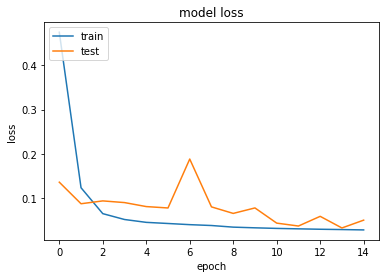

In [21]:
# summarize history for precision
# plt.plot(history.history['r_square'])
# plt.plot(history.history['val_r_square'])
# plt.title('model f1_score')
# plt.ylabel('f1_score')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# summarize history for loss
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
# X_true = np.array(np.concatenate([x for x, y in dt_test], axis=0))
# y_true = np.array(np.concatenate([y for x, y in dt_test], axis=0))
y_pred = np.array(best_model.predict(dt_test))

In [35]:
y_pred[:5]

array([[7.015294  , 0.67807186],
       [7.7041707 , 1.2876271 ],
       [6.1826096 , 0.46498358],
       [6.8059015 , 0.77406335],
       [6.2615256 , 0.5156933 ]], dtype=float32)

In [36]:
y_true[:5]

array([[6.67076632, 0.12221763],
       [7.67934389, 1.13140211],
       [6.13122649, 0.64185389],
       [6.81783057, 0.99325177],
       [6.11146734, 0.63127178]])

In [37]:
def error_benchmark(y_true, y_pred):
    true_s = np.exp(y_true[:, 0])/100
    true_mag = np.exp(y_true[:, 1])-1
    pred_s = np.exp(y_pred[:, 0])/100
    pred_mag = np.exp(y_pred[:, 1])-1
    
    error_s = true_s-pred_s
    error_mag = true_mag-pred_mag
    
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
    sns.histplot(error_s, kde=True, ax=axs[0])
    sns.histplot(error_mag, kde=True, ax=axs[1])

    legend_properties = {'weight':'bold'}    
    plt.tight_layout()
    ymin, ymax = axs[1].get_ylim()
    
    axs[0].set_xlabel('Second')
    axs[0].set_title('S-Wave Error (By Second)')
    
    axs[1].set_xlabel('Magnitude')
    axs[1].set_title('Magnitude Error (By Magnitude)')
    
    fig.tight_layout()
    
metric = tfa.metrics.RSquare(num_regressors=6000)
metric.update_state(np.exp(y_true[:, 0])/100, np.exp(y_pred[:, 0])/100)
result_s = round(metric.result().numpy()*100, 2)

metric = tfa.metrics.RSquare(num_regressors=6000)
metric.update_state(np.exp(y_true[:, 1])-1, np.exp(y_pred[:, 1])-1)
result_mag = round(metric.result().numpy()*100, 2)

print(f'\nAdjusted-RSquared S-Wave   : {result_s} %')
print(f'Adjusted-RSquared Magnitude: {result_mag} %\n')

true_s = np.exp(y_true[:, 0])/100
true_mag = np.exp(y_true[:, 1])-1
pred_s = np.exp(y_pred[:, 0])/100
pred_mag = np.exp(y_pred[:, 1])-1

error_s = true_s-pred_s
error_mag = true_mag-pred_mag

mean_error_s = np.mean(error_s)
std_error_s = np.std(error_s)

mean_error_mag = np.mean(error_mag)
std_error_mag = np.std(error_mag)

print(f'95.3% Confident Interval S-Wave: {round(mean_error_s-2*std_error_s, 2)} <> {round(mean_error_s+2*std_error_s, 2)} (Second)')
print(f'95.3% Confident Interval Magnitude: {round(mean_error_mag-2*std_error_mag, 2)} <> {round(mean_error_mag+2*std_error_mag, 2)} (Schala Richter)')


Adjusted-RSquared S-Wave   : 82.98 %
Adjusted-RSquared Magnitude: 75.93 %

95.3% Confident Interval S-Wave: -5.03 <> 4.82 (Second)
95.3% Confident Interval Magnitude: -0.98 <> 0.9 (Schala Richter)


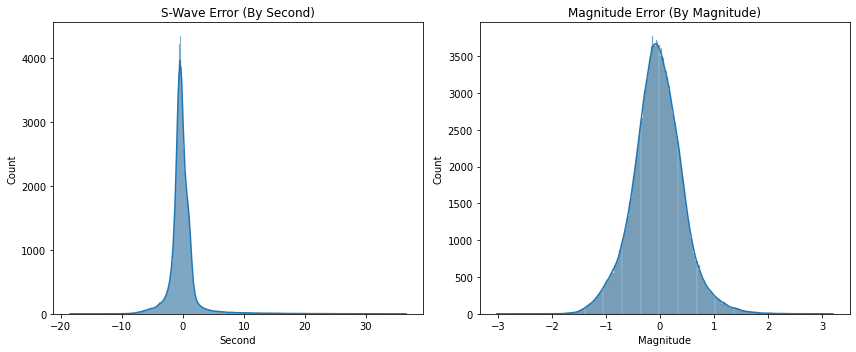

In [38]:
error_benchmark(y_true, y_pred)

In [39]:
def visualize_S_Mag(X_true, y_true, y_pred):
    true_s = np.exp(y_true[:, 0])/100
    pred_s = np.exp(y_pred[:, 0])/100
    
    idx_ = np.random.randint(0, len(true_s))
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(311)         

    plt.plot(np.linspace(0, 60, 6000), np.mean(X_true[idx_], axis=-1), 'k')
    legend_properties = {'weight':'bold'}    
    plt.tight_layout()
    ymin, ymax = ax.get_ylim()

    s_true = plt.vlines(true_s[idx_], ymin, ymax, color='b', linewidth=2, label='S-Arrival')
    s_pred = plt.vlines(pred_s[idx_], ymin, ymax, color='r',
                             linewidth=2, label='S-Predict-Arrival')

    plt.legend(handles=[s_true, s_pred],
               loc = 'upper right', borderaxespad=0., prop=legend_properties)        
    plt.ylabel('Mean of All Channel', fontsize=12) 

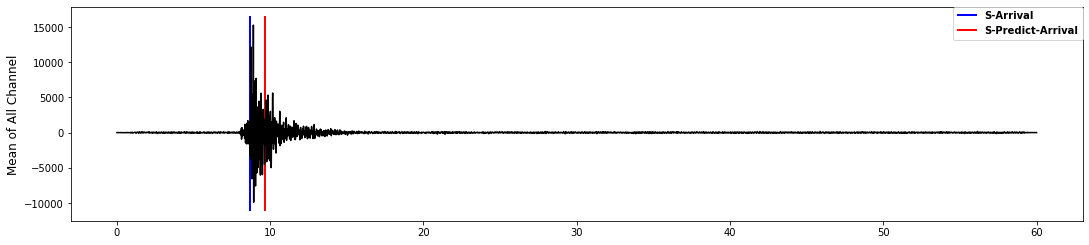

In [59]:
visualize_S_Mag(X_true, y_true, y_pred)

In [16]:
# %%time
# # Train
# tf_data_path_train = os.path.join(os.getcwd(), 'Prefetch Dataset', 'v2 (S-Mag)', 'Train')
# with open(tf_data_path_train + '/element_spec', 'rb') as in_:
#     es = pickle.load(in_)

# dt_train = tf.data.experimental.load(
#     tf_data_path_train, es, compression='GZIP'
# )

# # Test
# tf_data_path_test = os.path.join(os.getcwd(), 'Prefetch Dataset', 'v2 (S-Mag)',  'Test')
# with open(tf_data_path_test + '/element_spec', 'rb') as in_:
#     es = pickle.load(in_)

# dt_test = tf.data.experimental.load(
#     tf_data_path_test, es, compression='GZIP'
# )

# # Val
# tf_data_path_val = os.path.join(os.getcwd(), 'Prefetch Dataset', 'v2 (S-Mag)', 'Val')
# with open(tf_data_path_val + '/element_spec', 'rb') as in_:
#     es = pickle.load(in_)

# dt_val = tf.data.experimental.load(
#     tf_data_path_val, es, compression='GZIP'
# )

In [17]:
def create_feature(data_feature):
    rs = []
    for t in tqdm(data_feature.values):
        data_l = get_waveform(t)
        data_denoise = DenoiseWavelet(data_l, type='BayesShrink')
        rs.append(data_denoise)
    return np.array(rs)

def create_label(data_label):
    return np.array(data_label.values)
    
feature = create_feature(X[:100])
label = create_label(y[:100])

NameError: name 'X' is not defined

In [ ]:
feature.shape

In [ ]:
len(feature)

In [ ]:
model

In [151]:
import keras

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(6000), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [168]:
%%time
params = {'dim': (6000),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}

gen = DataGenerator(feature, label, **params)

Wall time: 994 µs
